In [1]:
# import common libraries
import pandas as pd # data manipulation and extraction
import numpy as np # vector operations
import matplotlib.pyplot as plt # plot library
import seaborn as sns # enhanced visual plot library
import pingouin as pg # statistics package for running tests in dataframes
import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
#pd.options.display.float_format = '{:.2f}'.format

# Load the data
data = pd.read_csv('../notebooks/data/2024-Feb-21_data.csv')

print(f'dataframe shape: {data.shape}')

dataframe shape: (1305, 358)


## Testing for Significant Difference
In this notebook, the theme will be to test the difference between patient groups and learning what may cause someone to respond to treatment.

- <u>group1</u> - n=275 patients who responded to treatment, by meeting the predetermined abstinence window<br>

- <u>group0</u> - n=471 patients who fail to respond to treatment

*Both groups completed 24 weeks of treatment total n=746 patients<br>

The following data will be analyzed<br>

- <u>Urine Drug Tests</u> - Scheduled once per week for 8 different drug classes once every 24 weeks.  Primary output measure is for positive opioid tests with secondary measure is for positive tests for other drug classes.<br>

    <u>group1</u> - n=4805 tests<br>
<br>
    <u>group0</u> - n=14935 tests<br>
<br>
- <u>Self Reported Use</u> - Patients filled out surveys once every 4 weeks.  Each survey included instances of drug use for 8 different drug classes over the previous 30 days.  Surveys were collected at week 0 (baseline), then weeks 4, 8, 12, 16, 20 and 24.<br>
<br>
<u>Medication Doses</u> - Patients were given Methadone or Buprenorphine for treatment.  The distribution of patients is listed as follows:

- <u>group1</u> - n=141 methadone and n=134 buprenorphine<br>
<br>
- <u>group2</u> - n=250 methadone and n=211 buprenophine
 

<br>
The definition of response is abstinence within a predetermined window, where the patient shows negative urine test for opioids during the final four weeks of treatment.<br>
<br>
First we will examine the statistical difference between groups and look for evidence in the data to show that the tests are robust.  The difference in patient data should serve as a risk signal.  Helping providers improve treatment, thus improving patient response. <br>
<br>


## Helper Functions
Since the dataset is very wide with over 350 columns, we created a few functions to automate the analysis.
- `plot_drug_tests()` - Will take input for `tests` and `surveys` for 8 different `drugclasses` and produce a plot showing the sum of positive tests for each drugclass for each week of treatment.  
<br>

- `drug_test_df()` - Will take same input as `plot_drug_test()` produces the dataframe for analysis without the plot.  There is option to analyze `meds` for medication doses
<br>



In [2]:
# create function to plot number of positive tests weekly for each drug class
def plot_drug_tests(df, type, drugclass, ax=None):
    """
    Plots the sum of drug test results for a specific drug class.

    Parameters:
    df (DataFrame): The input DataFrame containing the drug test data.
    type (str): The type of drug test, either 'test' or 'survey'.
    drugclass (str): The drug class to plot the results for.
    ax (Axes, optional): The matplotlib Axes object to plot the bar chart on. If not provided, a new Axes object will be created.

    Returns:
    ax (Axes): The matplotlib Axes object containing the bar chart.

    Raises:
    AssertionError: If the type is not 'test' or 'survey'.
    AssertionError: If the drugclass is not one of 'Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine'.
    """

    # assert that type is either 'test' or 'survey'
    assert type in ['test', 'survey'], 'type must be either "test" or "survey"'

    # assert that drugclass must be include Propoxyphene, Amphetamines,Cannabinoids, Benzodiazepines, Cocaine (not case sensitive)
    assert drugclass in ['Opiate300','Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine'], 'drugclass must be one of "Propoxyphene", "Amphetamines", "Methamphetamine", "Cannabinoids", "Benzodiazepines", "Cocaine" or "Opiate300"'

    # filter df to total_visits == 26, this filters patients that completed treatment
    df = df[df['total_visits'] == 26]

    # create dataframe with columns for type and drug class
    df = df[[col for col in df.columns if col.startswith(type+'_') and drugclass in col]]

    # remove text and leave numbers in column names
    df.columns = [col.split('_')[-1] for col in df.columns]

    # fill nan values with 0
    df = df.fillna(0)

    # replace -5.0 with 0.0 
    df = df.replace(-5.0, 0.0)

    # plot the sum of the columns

    # set condition if axis object is not passed
    if ax is None:
        ax = plt.gca()
    sns.barplot(x=df.columns, y=df.sum(), ax=ax, palette='Blues_d')
    
    # create title
    ax.set_title(f' {drugclass} tests', fontsize=15)
    
    # remove the x axis 
    ax.set_xticklabels('')

    return ax

In [3]:

# create function to plot number of positive tests weekly for each drug class
def drug_test_df(df, type, drugclass, ax=None):
    """
    Plots the sum of drug test results for a specific drug class.

    Parameters:
    df (DataFrame): The input DataFrame containing the drug test data.
    type (str): The type of drug test, either 'test' or 'survey'.
    drugclass (str): The drug class to plot the results for.
    ax (Axes, optional): The matplotlib Axes object to plot the bar chart on. If not provided, a new Axes object will be created.

    Returns:
    ax (Axes): The matplotlib Axes object containing the bar chart.

    Raises:
    AssertionError: If the type is not 'test' or 'survey'.
    AssertionError: If the drugclass is not one of 'Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine'.
    """

    # assert that type is either 'test' or 'survey'
    assert type in ['test', 'survey','meds'], f'{type} not a valid type for reporting'

    # assert that drugclass must be include Propoxyphene, Amphetamines,Cannabinoids, Benzodiazepines, Cocaine (not case sensitive)
    assert drugclass in ['Opiate300','Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine', 'cannabis','oxycodone','methadone','amphetamine','crystal','opiates','benzodiazepines','propoxyphene','cannabis','cocaine','oxycodone','methadone','amphetamine','methamphetamine','opiates','benzodiazepines','propoxyphene'],f'{drugclass} not a valid drug class'

    # filter df to total_visits == 26, this filters patients that completed treatment
    df = df[df['total_visits'] == 26]

    # create dataframe with columns for type and drug class
    df = df[[col for col in df.columns if col.startswith(type+'_') and drugclass in col]]

    # remove text and leave numbers in column names
    df.columns = [col.split('_')[-1] for col in df.columns]

    # fill nan values with 0
    df = df.fillna(0)

    # replace -5.0 with 0.0 
    df = df.replace(-5.0, 0.0)

    # set condition for aggregation by type

    if type == 'meds':
        df = df.mean()
    else:
        df = df.sum()

    df = pd.DataFrame(df)

    df = df.rename(columns={0: f'{drugclass.lower()}'})

    return df

### Before getting into the analysis, show the cumulative response rate 

In [4]:
# add appropriate columns for plotting

# calculate the cumulative sum of responders
cumulative_response = pd.Series(data['responder']).cumsum()

# calculate the cumulative sum of non-responders
cumulative_non_response = (1 - pd.Series(data['responder'])).cumsum()

# calculate the cumulative response rate
cumulative_response_rate = cumulative_response / (cumulative_response + cumulative_non_response)

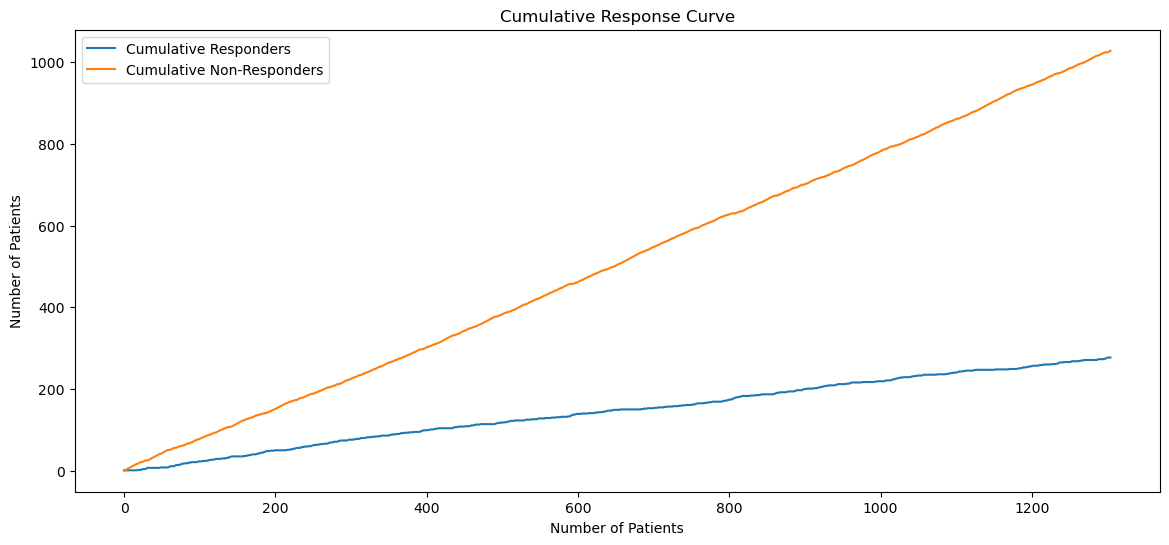

In [5]:
# plot cumulative response curve
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cumulative_response, label='Cumulative Responders')
ax.plot(cumulative_non_response, label='Cumulative Non-Responders')
ax.set_xlabel('Number of Patients')
ax.set_ylabel('Number of Patients')
ax.set_title('Cumulative Response Curve')
ax.legend()
plt.show()


In [6]:
# responders and non-responders
print(f'Number of responders: {cumulative_response.iloc[-1]}')
print(f'Number of non-responders: {cumulative_non_response.iloc[-1]}')

Number of responders: 277
Number of non-responders: 1028


### At this point, we will segment our data into 2 patient groups

In [7]:
# filter groups by responder class and total visits, indicating patient completed treatment
group1 = data.loc[(data.responder==1)&(data.total_visits==26)]
group0 = data.loc[(data.responder==0)&(data.total_visits==26)]

## First we will analyze the urine drug tests 

### Create dataframe for group1

In [8]:
# create dataframe with number of drug test per drug class by treatment outcome

# these are the patients that responded to treatment

# create for loop to create a df for each drug class
for drug in ['Opiate300','Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine']:
 # turn each drug class into a dataframe, with aggregation of drug test results
 globals()[f'{drug}'] = drug_test_df(group1, 'test', drug)

# merge all the dataframes
drug_test_r1 = pd.concat([Opiate300, Propoxyphene, Amphetamines, Methamphetamine, Cannabinoids, Benzodiazepines, Cocaine], axis=1)

# add '-r1' to the end of each column name
drug_test_r1.columns = [f'{col}_r1' for col in drug_test_r1.columns]

drug_test_r1

,opiate300_r1,propoxyphene_r1,amphetamines_r1,methamphetamine_r1,cannabinoids_r1,benzodiazepines_r1,cocaine_r1
0,212.0,8.0,11.0,14.0,57.0,49.0,71.0
1,81.0,2.0,12.0,16.0,62.0,31.0,60.0
2,66.0,1.0,12.0,15.0,64.0,21.0,63.0
3,58.0,3.0,10.0,14.0,56.0,18.0,62.0
4,47.0,1.0,10.0,10.0,60.0,18.0,60.0
5,44.0,2.0,14.0,14.0,55.0,17.0,49.0
6,40.0,0.0,14.0,14.0,54.0,30.0,51.0
7,35.0,2.0,10.0,10.0,56.0,29.0,59.0
8,32.0,4.0,9.0,12.0,51.0,24.0,60.0
9,35.0,4.0,11.0,15.0,57.0,24.0,55.0


### create dataframe for group0

In [9]:
# create dataframe with number of drug test per drug class by treatment outcome

# these are the patients that did not respond to treatment

# create for loop to create a df for each drug class
for drug in ['Opiate300','Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine']:
 # turn each drug class into a dataframe
 globals()[f'{drug}'] = drug_test_df(group0, 'test', drug)

# merge all the dataframes
drug_test_r0 = pd.concat([Opiate300, Propoxyphene, Amphetamines, Methamphetamine, Cannabinoids, Benzodiazepines, Cocaine], axis=1)

# add '_r1' to the end of each column name
drug_test_r0.columns = [f'{col}_r0' for col in drug_test_r0.columns]

drug_test_r0


,opiate300_r0,propoxyphene_r0,amphetamines_r0,methamphetamine_r0,cannabinoids_r0,benzodiazepines_r0,cocaine_r0
0,423.0,6.0,26.0,35.0,108.0,90.0,187.0
1,249.0,6.0,21.0,29.0,100.0,80.0,159.0
2,224.0,5.0,23.0,31.0,94.0,63.0,167.0
3,199.0,3.0,27.0,31.0,91.0,59.0,155.0
4,206.0,4.0,22.0,29.0,105.0,58.0,157.0
5,182.0,2.0,24.0,33.0,100.0,62.0,136.0
6,229.0,3.0,19.0,25.0,100.0,86.0,148.0
7,205.0,4.0,25.0,29.0,98.0,70.0,157.0
8,208.0,4.0,28.0,33.0,110.0,70.0,141.0
9,189.0,5.0,22.0,28.0,97.0,67.0,142.0


### Test for evidence of statistical significance, in difference of test results between different patient groups

In [10]:
# create function to test each drug class for significance between difference in tests between groups
def calculate_test_pvalues(group1, group2):
    """
    Calculate test p-values for different drug classes between two groups.

    Parameters:
    group1 (DataFrame): Dataframe containing the data for group 1.
    group2 (DataFrame): Dataframe containing the data for group 2.

    Returns:
    DataFrame: A dataframe containing the test p-values, significance, confidence intervals, cohen's d, Bayes Factor (BF10), and power for each drug class.
    """
    
    pval = []
    significance = []
    ci = []
    cd_list = []  
    bf10 = []
    power = []

    # perform ttest between each drug class
    for drug in ['opiate300','propoxyphene', 'amphetamines', 'methamphetamine', 'cannabinoids', 'benzodiazepines', 'cocaine']:
        t = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['p-val'][0]
        pval.append(t)
        if t < 0.05:
            significance.append('True')
        else:
            significance.append('False')
        c = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['CI95%'][0].tolist()
        c = ', '.join(map(str, c))
        ci.append(c)
        cd = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['cohen-d'][0]
        cd_list.append(cd)  
        b = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['BF10'][0]
        bf10.append(b)
        p = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['power'][0]
        power.append(p)

    test_pvs = pd.DataFrame(
        {'drugClass':['opiate300','propoxyphene', 'amphetamines', 'methamphetamine', 'cannabinoids', 'benzodiazepines', 'cocaine'],
         'pvalue':pval,
         'significance':significance,
         'CI95%':ci,
         'cohen-d':cd_list,
         'BF10:':bf10,
         'power':power})

    return test_pvs

test_pvs = calculate_test_pvalues(drug_test_r1, drug_test_r0)

test_pvs

,drugClass,pvalue,significance,CI95%,cohen-d,BF10:,power
0,opiate300,1.464256e-18,True,"-204.4, -153.04",3.957760,2.0e+15,1.000000
1,propoxyphene,4.031098e-03,True,"-2.27, -0.45",0.854462,9.944,0.841359
2,amphetamines,2.614400e-22,True,"-19.55, -15.49",4.905620,8.486e+18,1.000000
3,methamphetamine,1.094534e-25,True,"-25.4, -20.92",5.891839,1.624e+22,1.000000
4,cannabinoids,6.677985e-28,True,"-46.43, -39.09",6.619719,2.325e+24,1.000000
5,benzodiazepines,2.746061e-25,True,"-48.65, -39.91",5.767780,6.638e+21,1.000000
6,cocaine,7.019927e-35,True,"-103.27, -91.53",9.443339,1.493e+31,1.000000


### There are significant differences in all drug classes between different patient groups
Now that we've identified significant differences in clinical data, we will inspect those values further.  We expect to establish thresholds for risk with patient groups to help improve treatment outcomes.

### Now we will inspect the surveys for self reported drug use, from the same patient groups.
We will apply the same statistical rigor to see if there are significant differences in surveys from different patient groups

### create a dataframe with the sum of survey results from each different 

### starting with group1

In [11]:
# create loop to create a df for each drug class for survey data

for drug in ['cannabis','cocaine','oxycodone','methadone','amphetamine','crystal','opiates','benzodiazepines','propoxyphene']:
    # turn each drug class into a dataframe
    globals()[f'{drug}'] = drug_test_df(group1, 'survey', drug)
    
# merge all the dataframes
from functools import reduce

drug_survey_r1 = reduce(lambda x, y: pd.merge(x, y, right_index=True,left_index=True), [cannabis, cocaine, oxycodone, methadone, amphetamine, crystal, opiates, benzodiazepines, propoxyphene])

# add '-r1' to the end of each column name
drug_survey_r1.columns = [f'{col}_r1' for col in drug_survey_r1.columns]

drug_survey_r1

,cannabis_r1,cocaine_r1,oxycodone_r1,methadone_r1,amphetamine_r1,crystal_r1,opiates_r1,benzodiazepines_r1,propoxyphene_r1
0,796.0,641.0,1145.0,543.0,52.0,76.0,6151.0,194.0,4.0
4,645.0,520.0,149.0,11.0,18.0,72.0,1015.0,56.0,0.0
8,700.0,412.0,27.0,28.0,14.0,69.0,169.0,51.0,3.0
12,695.0,430.0,20.0,1.0,30.0,94.0,209.0,83.0,6.0
16,655.0,359.0,37.0,4.0,18.0,49.0,63.0,85.0,5.0
20,738.0,356.0,8.0,8.0,6.0,45.0,24.0,94.0,4.0
24,688.0,351.0,10.0,12.0,15.0,58.0,18.0,52.0,3.0


### now to group0

In [12]:
# create loop to create a df for each drug class for survey data

for drug in ['cannabis','cocaine','oxycodone','methadone','amphetamine','crystal','opiates','benzodiazepines','propoxyphene']:
    # turn each drug class into a dataframe
    globals()[f'{drug}'] = drug_test_df(group0, 'survey', drug)
    
# merge all the dataframes
from functools import reduce

drug_survey_r0 = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True), [cannabis, cocaine, oxycodone, methadone, amphetamine, crystal, opiates, benzodiazepines, propoxyphene])

# add '-r1' to the end of each column name
drug_survey_r0.columns = [f'{col}_r0' for col in drug_survey_r0.columns]

# rename columns
drug_survey_r0

drug_survey_r0

,cannabis_r0,cocaine_r0,oxycodone_r0,methadone_r0,amphetamine_r0,crystal_r0,opiates_r0,benzodiazepines_r0,propoxyphene_r0
0,986.0,1624.0,1026.0,618.0,71.0,170.0,11815.0,233.0,3.0
4,1046.0,1167.0,156.0,45.0,33.0,199.0,3270.0,202.0,2.0
8,1044.0,806.0,92.0,8.0,2.0,180.0,1333.0,209.0,0.0
12,1099.0,1089.0,85.0,5.0,11.0,259.0,1505.0,221.0,0.0
16,1228.0,885.0,95.0,13.0,10.0,267.0,1219.0,197.0,1.0
20,1167.0,847.0,47.0,13.0,9.0,264.0,1200.0,221.0,1.0
24,1050.0,1150.0,72.0,18.0,55.0,255.0,1600.0,265.0,1.0


In [13]:
def calculate_survey_pvalues(group1, group2):
    
    tests = []
    significance = []
    ci = [] 
    cd_list = []
    bf10 = [] 
    power = []

    # perform ttest between each drug class
    for drug in ['cannabis','cocaine','oxycodone','methadone','amphetamine','crystal','opiates','benzodiazepines','propoxyphene']:
        t = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['p-val'][0]
        tests.append(t)
        if t < 0.05:
            significance.append('True')
        else:
            significance.append('False')
        c = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['CI95%'][0].tolist()
        c = ', '.join(map(str, c))
        ci.append(c)
        cd = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['cohen-d'][0]
        cd_list.append(cd)  
        b = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['BF10'][0]
        bf10.append(b)
        p = pg.ttest(group1[f'{drug}_r1'], group2[f'{drug}_r0'], paired=False)['power'][0]
        power.append(p)

    survey_pvs = pd.DataFrame(
        {'drugClass':['cannabis','cocaine','oxycodone','methadone','amphetamine','crystal','opiates','benzodiazepines','propoxyphene'],
         'pvalue':tests,
         'significance':significance,
         'CI95%':ci,
         'cohen-d':cd_list,
         'BF10:':bf10,
         'power':power})

    return survey_pvs

survey_pvs = calculate_survey_pvalues(drug_survey_r1, drug_survey_r0)

survey_pvs

,drugClass,pvalue,significance,CI95%,cohen-d,BF10:,power
0,cannabis,2.220957e-07,True,"-466.65, -305.63",5.585849,3.612e+04,1.000000
1,cocaine,1.086873e-04,True,"-890.93, -394.5",3.015653,171.475,0.999288
2,oxycodone,9.051519e-01,False,"-477.98, 427.41",0.065051,0.448,0.051446
3,methadone,8.905510e-01,False,"-266.38, 234.09",0.075131,0.449,0.051929
4,amphetamine,6.471079e-01,False,"-30.62, 19.76",0.250974,0.48,0.071754
5,crystal,8.002115e-07,True,"-199.52, -123.63",4.959064,1.161e+04,1.000000
6,opiates,2.533300e-01,False,"-5749.5, 1665.79",0.641377,0.706,0.197526
7,benzodiazepines,3.349328e-05,True,"-178.59, -87.99",3.426633,458.72,0.999948
8,propoxyphene,1.226927e-02,True,"0.63, 4.23",1.573894,4.525,0.771252


In [14]:
totalgroup = group1.shape[0] + group0.shape[0]

In [15]:
# show confidence interval for differenc in mean positive tests for each drug class
ci = survey_pvs.loc[:,['CI95%']]

# separate the confidence intervals into two columns
ci = ci['CI95%'].str.split(', ', expand=True)

ci.columns = ['lower', 'upper']

ci = ci.astype(float)

ci['upp_avg_pos_test'] = ci['lower']/totalgroup
ci['low_avg_pos_test'] = ci['upper']/totalgroup

# drugclass
ci['drugClass'] = survey_pvs['drugClass']

# move  drugclass to first column
cols = ci.columns.tolist()
cols = cols[-1:] + cols[:-1]
ci = ci[cols]

ci


,drugClass,lower,upper,upp_avg_pos_test,low_avg_pos_test
0,cannabis,-466.65,-305.63,-0.634035,-0.415258
1,cocaine,-890.93,-394.50,-1.210503,-0.536005
2,oxycodone,-477.98,427.41,-0.649429,0.580720
3,methadone,-266.38,234.09,-0.361929,0.318057
4,amphetamine,-30.62,19.76,-0.041603,0.026848
5,crystal,-199.52,-123.63,-0.271087,-0.167976
6,opiates,-5749.50,1665.79,-7.811821,2.263302
7,benzodiazepines,-178.59,-87.99,-0.242649,-0.119552
8,propoxyphene,0.63,4.23,0.000856,0.005747


In [16]:
# show difference in avg weekly positive tests
# for each responder group 
opiates1 = drug_test_df(group1, 'test', 'Opiate300')
opiates0 = drug_test_df(group0, 'test', 'Opiate300')

opiates = pd.concat([opiates1, opiates0], axis=1)

opiates.columns = ['opiates_r1', 'opiates_r0']

opiates

,opiates_r1,opiates_r0
0,212.0,423.0
1,81.0,249.0
2,66.0,224.0
3,58.0,199.0
4,47.0,206.0
5,44.0,182.0
6,40.0,229.0
7,35.0,205.0
8,32.0,208.0
9,35.0,189.0


## Plot Results

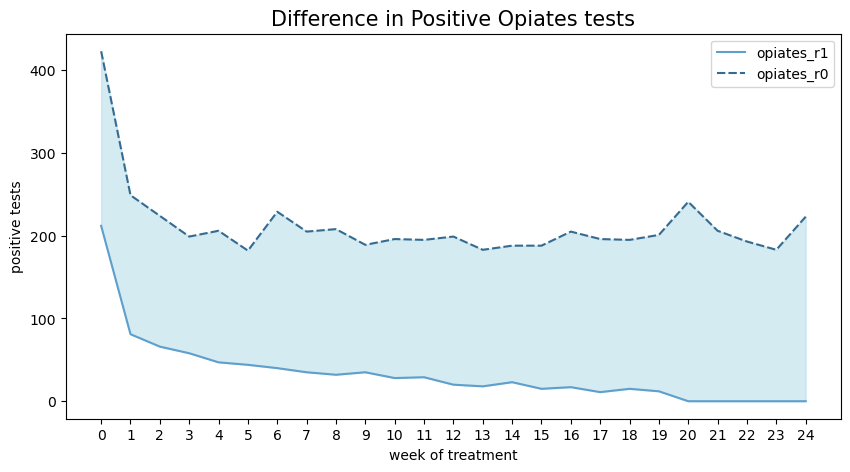

In [17]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=opiates, ax=ax, palette='Blues_d')
ax.fill_between(opiates.index, opiates['opiates_r1'], opiates['opiates_r0'], color='lightblue', alpha=0.5)
ax.set_title('Difference in Positive Opiates tests', fontsize=15)
ax.set_xlabel('week of treatment')
ax.set_ylabel('positive tests')
plt.show()



## Look at Change in Patterns of Drug Use for All Drug Classes

### Start with Responder 1 group
- Responder - meets predefined abstinence window - final 4 weeks of treatment

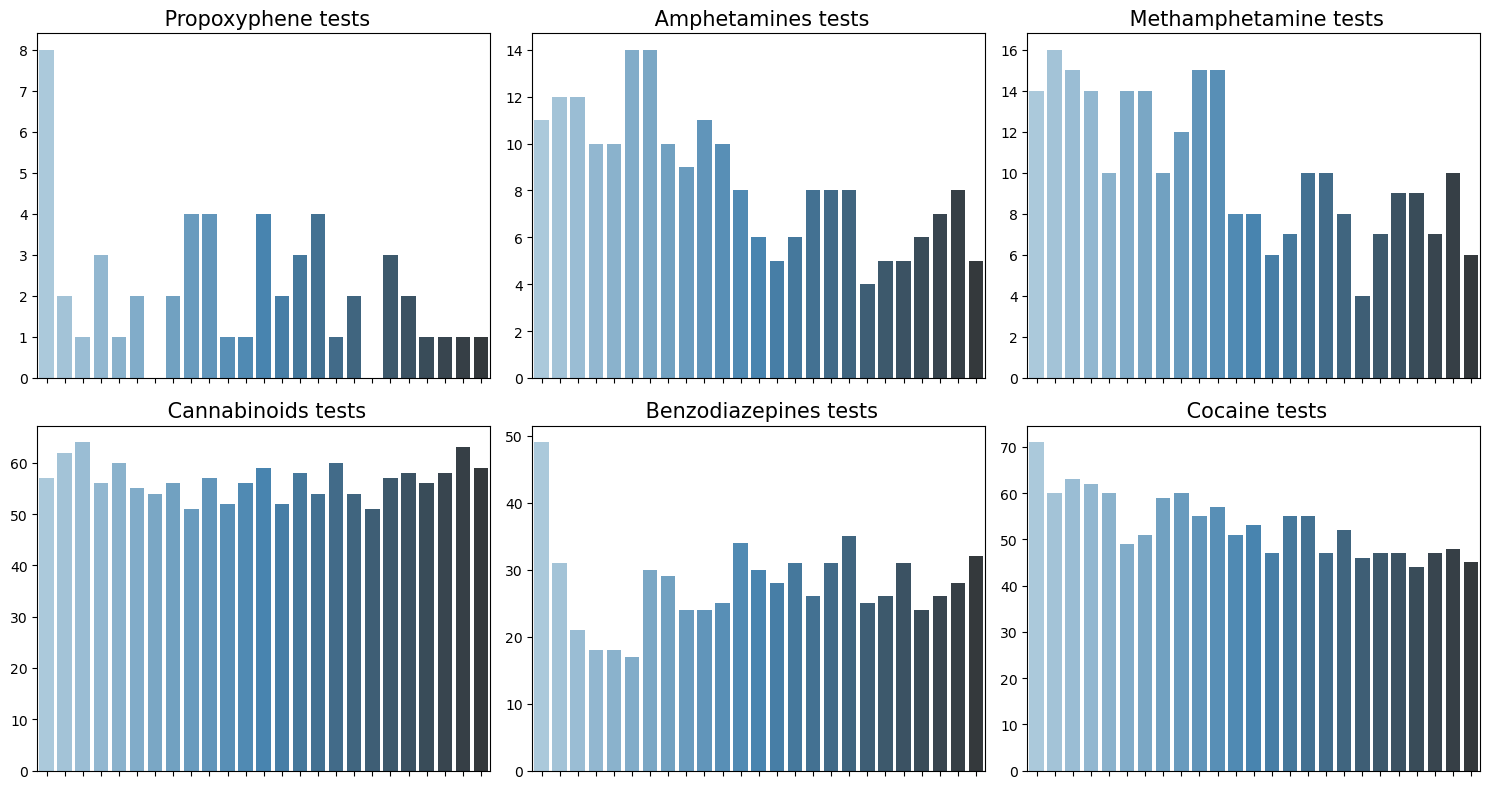

In [18]:
# lineplot for avg weekly positive tests for each drug class
# for each responder group
fig, ax = plt.subplots(2, 3, figsize=(15, 8))  
for i, drug in enumerate(['Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine']):
    plot_drug_tests(group1, 'test', drug, ax=ax.flatten()[i])
plt.tight_layout()
plt.show()

### Now responder 0 group
- Non - responder - Does not meet pre-defined abstinence window

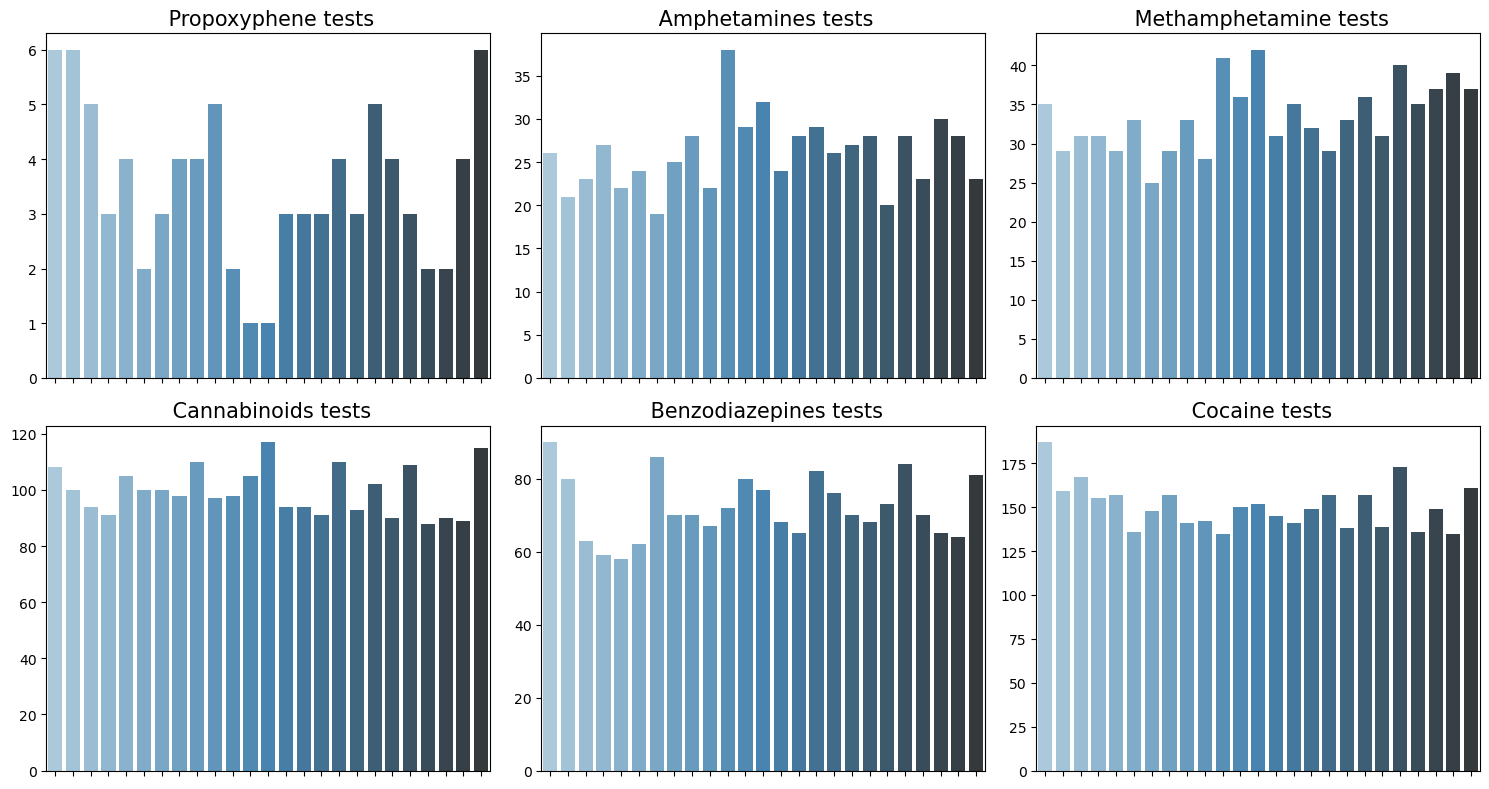

In [19]:
# lineplot for avg weekly positive tests for each drug class
# for each responder group
fig, ax = plt.subplots(2, 3, figsize=(15, 8))  
for i, drug in enumerate(['Propoxyphene', 'Amphetamines', 'Methamphetamine', 'Cannabinoids', 'Benzodiazepines', 'Cocaine']):
    plot_drug_tests(group0, 'test', drug, ax=ax.flatten()[i])
plt.tight_layout()
plt.show()

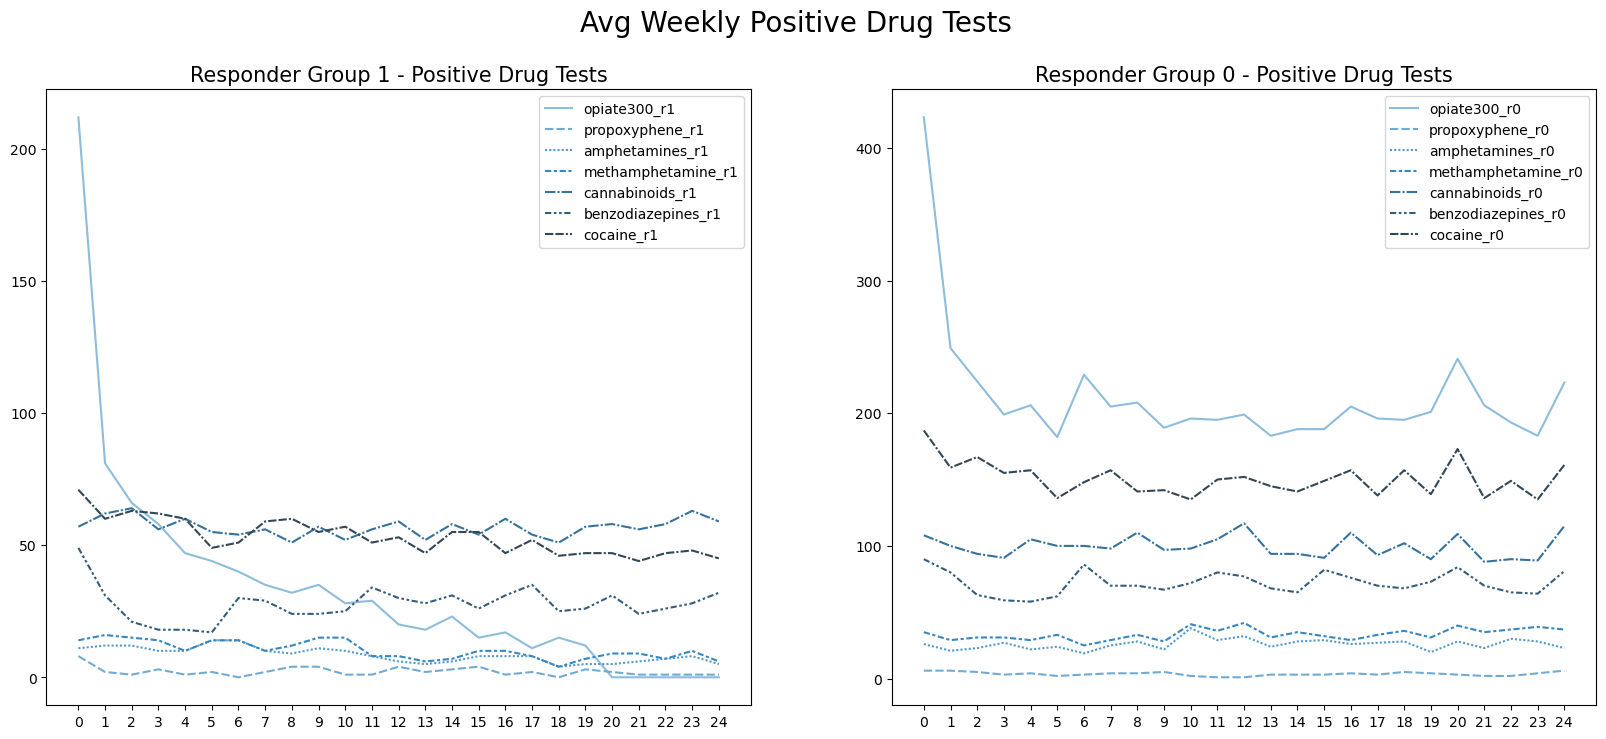

In [20]:
# create 2 plots adjacent
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=drug_test_r1, palette='Blues_d', ax=ax[0])
sns.lineplot(data=drug_test_r0, palette='Blues_d', ax=ax[1])
fig.suptitle('Avg Weekly Positive Drug Tests', fontsize=20)
ax[0].set_title('Responder Group 1 - Positive Drug Tests', fontsize=15)
ax[1].set_title('Responder Group 0 - Positive Drug Tests', fontsize=15)
plt.show()


### Let's examine how patients do half way through threatment?

In [21]:
# look at weeks with higher than average positive tests
# look at self reported use and medication levels too

week12_g1 = group1.agg({'test_Opiate300_12':'sum','meds_methadone_12':np.mean,'survey_opiates_12':np.mean}).to_frame().rename(columns={0:'group1'}).round()

week12_g0 = group0.agg({'test_Opiate300_12':'sum','meds_methadone_12':np.mean,'survey_opiates_12':np.mean}).to_frame().rename(columns={0:'group0'}).round()

week12 = pd.concat([week12_g1, week12_g0], axis=1)

print(f'Rsponder group1 and group 0: Statuss at week 12')
week12

Rsponder group1 and group 0: Statuss at week 12


,group1,group0
test_Opiate300_12,10.0,169.0
meds_methadone_12,324.0,323.0
survey_opiates_12,1.0,4.0


### Is there a pattern between responder groups, starting early in treatment?

In [22]:
# average positive tests for the first 12 weeks of treatment
opiates.iloc[0:12,:].mean().to_frame().rename(columns={0:'avg_pos_tests'}).round().T

,opiates_r1,opiates_r0
avg_pos_tests,59.0,225.0


In [23]:
# averg positive tests for the final 12 weeks of treatment
opiates.iloc[12:,:].mean().to_frame().rename(columns={0:'avg_pos_tests'}).round().T

,opiates_r1,opiates_r0
avg_pos_tests,10.0,200.0


### Patient groups seem to be goin in the right direction
- Responders who do well the first half of treatment, improve by 83% decrease in positive test for final 24 weeks
- While non-responders seem to improve by 11% decrease in positive tests

Conclusion: In general, patients who remain in treatment, show decline in positive opioid test by 11% - 83% for the 2nd half of treatment


## Next we will analyze medication doses

### First we will segment the medication doses for methadone into two patient groups

In [24]:
# create dataframe for med doses for each patient group

# responder 1 patient group
methadone_g1 = drug_test_df(group1, 'meds', 'methadone').round(2)

# responder 0 patient group
methadone_g0 = drug_test_df(group0, 'meds', 'methadone').round(2)

# combine datasets for analysis
diff = pd.concat([methadone_g1, methadone_g0], axis=1)

# rename columns    
diff.columns = ['responder', 'non_responder']

# sample of the data
diff

,responder,non_responder
0,41.18,38.48
1,172.36,180.55
2,220.08,233.76
3,238.85,232.54
4,262.58,265.41
5,276.72,257.55
6,267.93,271.39
7,289.28,273.47
8,301.04,287.68
9,310.83,290.44


In [25]:
# test for equal variance
pg.homoscedasticity(diff)

,W,pval,equal_var
levene,0.193452,0.662033,True


### Test for significance between the different patient groups

In [26]:
# set significance level
alpha = 0.05

ttest = pg.ttest(diff.responder, diff.non_responder, paired=False, alternative='two-sided')

display(ttest)

if ttest['p-val'][0] < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis.') 
    print('\n')
    print('There is no significant difference in methadone doses between the two groups')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.724787,48,two-sided,0.472101,"[-32.16, 68.41]",0.205001,0.351,0.109514


Fail to reject the null hypothesis.


There is no significant difference in methadone doses between the two groups


## Visualize the difference

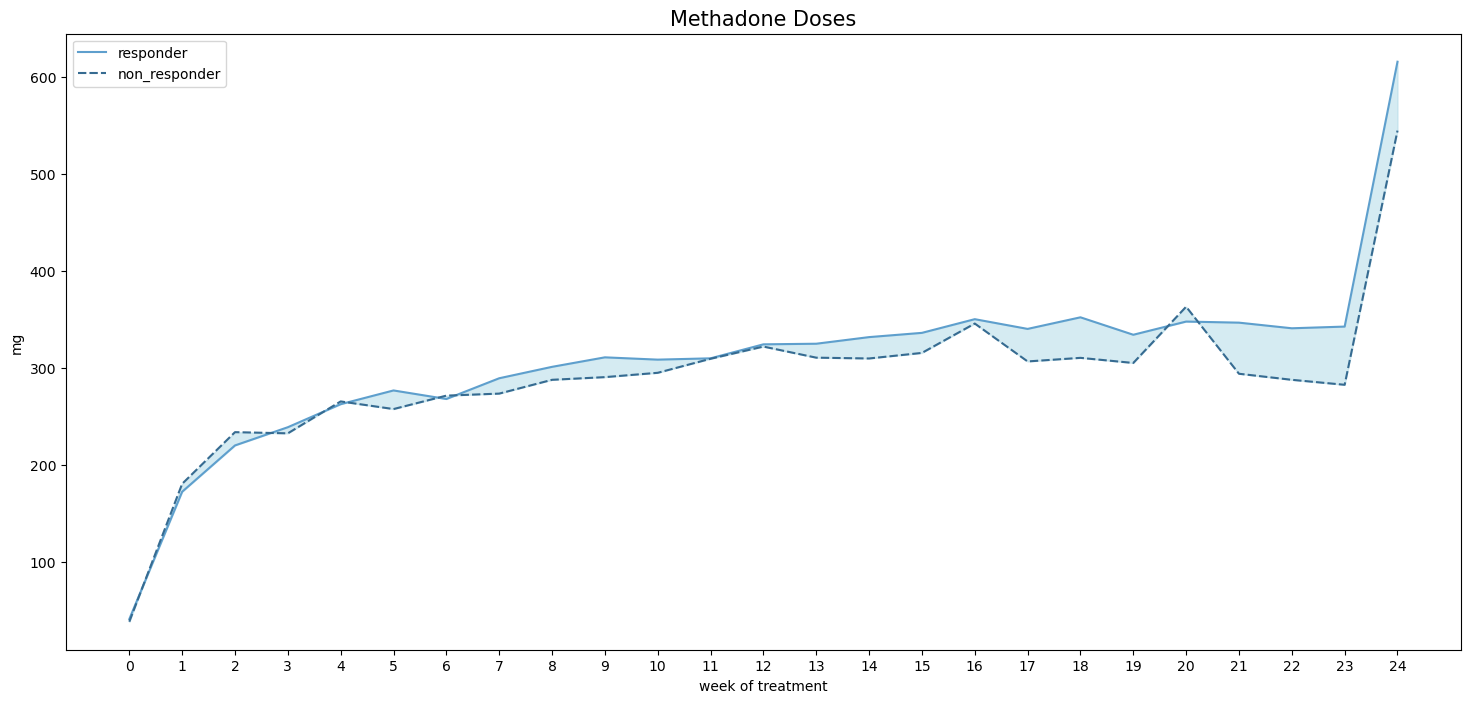

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.lineplot(data=diff, ax=ax, palette='Blues_d')
ax.fill_between(diff.index, diff['responder'], diff['non_responder'], color='lightblue', alpha=0.5)
ax.set_title('Methadone Doses', fontsize=15)
ax.set_xlabel('week of treatment')
ax.set_ylabel('mg')
plt.show()
